In [1]:
import numpy as np
import copy
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
m = 4
n = 5

Y = np.random.rand(m, n)
l = 1.0
gamma = 0.1
max_iter = 100

In [3]:
u = np.random.rand(1,2)
u

array([[0.83276268, 0.18889349]])

In [4]:
G = np.array([[-1,1,0],[0,-1,1]])
U, S, VT = np.linalg.svd(G)
S_full = np.zeros((2, 3))
S_full[:, :len(S)] = np.diag(S)
print(U)
print(S_full)
VT

[[-0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]
[[1.73205081 0.         0.        ]
 [0.         1.         0.        ]]


array([[ 4.08248290e-01, -8.16496581e-01,  4.08248290e-01],
       [-7.07106781e-01, -2.78976253e-16,  7.07106781e-01],
       [ 5.77350269e-01,  5.77350269e-01,  5.77350269e-01]])

In [5]:
def solve_case_1(w,l,gamma):
    pho = l/gamma
    G = np.array([[-1,1,0],[0,-1,1]])
    B = np.linalg.inv(np.dot(G,G.T))
    B = np.dot(B,np.dot(G,w.T))
    pho_max = np.linalg.norm(B)
    if pho > pho_max:
        B = np.linalg.inv(np.dot(G,G.T))
        B = np.dot(G.T,B)
        B = np.dot(B,G)
        u = np.dot(np.identity(3)-B,w.T)

    else:
        U, S, VT = np.linalg.svd(G)
        S_full = np.zeros((2, 3))
        S_full[:, :len(S)] = np.diag(S)
        w_hat = np.dot(S_full,np.dot(VT,w.T))
        w_hat = w_hat.T
        c0 = (pho**8)*9-(pho**6)*(w_hat[0]**2+(w_hat[1]**2)*9)
        c1 = 2*(pho**6)*(3+9) - 2*(pho**4)*(w_hat[0]**2+w_hat[1]**2*3)
        c2 = pho**4*(9+1+12)-pho**2*(w_hat[0]**2+w_hat[1]**2)
        c3 = 2*pho**2*4

        coefficients = [1,c3,c2,c1,c0]
        roots = np.roots(coefficients)
        positive_real_roots = [root.real for root in roots if np.isreal(root) and root.real > 0]
        
        alpha =np.min(positive_real_roots)
        B = np.linalg.inv(np.dot(G,G.T)+alpha/(pho**2)*np.identity(2))
        B = np.dot(G.T,B)
        B = np.dot(B,G)
        u = np.dot(np.identity(3)-B,w.T)

    return u.T


In [6]:
def solve_case_2(w,l,gamma):
    pho = l/gamma
    if w[0]>w[1] + 2*pho:
        u = np.array([w[0]-pho,w[1]+pho])
    elif w[0] < w[1]-2*pho:
        u = np.array([w[0]+pho,w[1]-pho])
    else:
        u = np.array([(w[0]+w[1])/2,(w[0]+w[1])/2])
    return u.T

In [7]:
def minfunc(V,l,gamma,k):
    m,n = V.shape
    X = copy.deepcopy(V)
    for p in range(m):
        for q in range(n):
            if (p-q) % 3 != k:
                continue
            if (p < m-1) and (q < n-1):
                w = np.array([V[p,q+1],V[p,q],V[p+1,q]])
                u = solve_case_1(w,l,gamma)
                X[p,q+1] = u[0]
                X[p,q] = u[1]
                X[p+1,q] = u[2]
            
            if (p == m-1) and (q < n-1):
                w = np.array([V[p,q+1],V[p,q]])
                u = solve_case_2(w,l,gamma)
                X[p,q+1] = u[0]
                X[p,q] = u[1]
            
            if (p < m-1) and (q == n-1):
                w = np.array([V[p,q],V[p+1,q]])
                u = solve_case_2(w,l,gamma)
                X[p,q] = u[0]
                X[p+1,q] = u[1]
    return X




In [8]:
def FAD(Y,l,gamma):
    m,n = Y.shape
    Z = copy.deepcopy(Y)
    X = [copy.deepcopy(Y), copy.deepcopy(Y), copy.deepcopy(Y)]
    theta = [np.zeros((m,n)),np.zeros((m,n)),np.zeros((m,n))]
    V = [np.zeros((m,n)),np.zeros((m,n)),np.zeros((m,n))]
    for iter in range(max_iter):

        for k in range(3):
            V[k] = Z-theta[k]
            X[k] = minfunc(V[k],l,gamma,k)
        Z = (Y+theta[0]+theta[1]+theta[2]+X[0]+X[1]+X[2])/(1+3*gamma)

        for k in range(3):
            theta[k] = theta[k] + X[k] - Z
    
    return Z


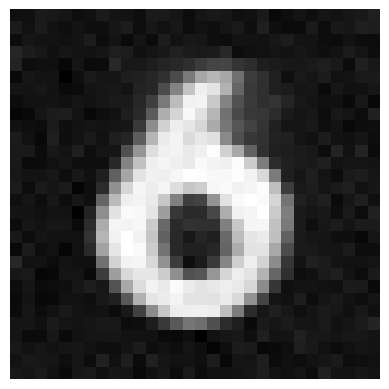

In [34]:
image_path = '6.png'  # 替换为你的图片路径
image = Image.open(image_path)

# 转换为灰度图像
gray_image = image.convert('L').resize((30,30))

# 将灰度图像转换为 NumPy 数组
gray_image_np = np.array(gray_image)


def add_gaussian_noise(image, mean=0, std=5):
    noise = np.random.normal(mean, std, image.shape)  # 生成高斯噪声
    noisy_image = image + noise  # 添加噪声
    noisy_image = np.clip(noisy_image, 0, 255)  # 确保值在[0, 255]范围内
    return noisy_image

def add_stripe_noise(image, stripe_gap=3, noise_mean=0, noise_std=25):
    # 获取图像的高度和宽度
    height, width = image.shape[:2]

    # 创建一个与输入图像大小相同的噪声矩阵
    noisy_image = image.copy()
    # 遍历图像，每隔stripe_gap个像素添加噪声
    for y in range(0, height, stripe_gap):
        for x in range(width):

            # 在位置 (y, x) 添加高斯噪声
            noise = np.random.normal(noise_mean, noise_std, 1)  # 对每个通道添加噪声
            noisy_image[y, x] = np.clip(noisy_image[y, x] + noise, 0, 255)  # 添加噪声并裁剪到合法范围

    return noisy_image
# 添加噪声到图像
image = add_gaussian_noise(gray_image_np)
plt.imshow(image, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()

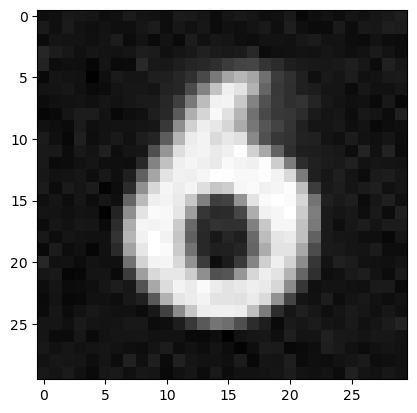

In [37]:
filter_image = FAD(image,l=1,gamma = 20)
plt.imshow(filter_image, cmap='gray')

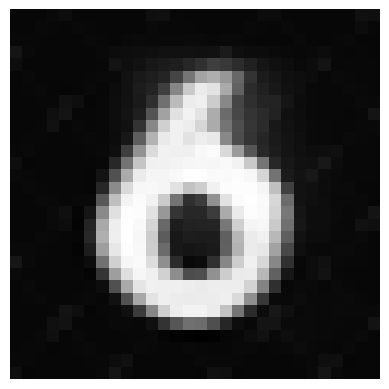

In [11]:
plt.imshow(gray_image_np, cmap='gray')
plt.axis('off')  # 不显示坐标轴
plt.show()